# Retrieval-Augmented Shopping Assistant - EDA

This notebook explores the ABO dataset for initial insights.

In [1]:
import pandas as pd

In [2]:
# Load ABO image dataset
df_img = pd.read_csv("/kaggle/input/amazon-berkeley-objects/images/metadata/images.csv")  # or csv if applicable

(398212, 4)
Index(['image_id', 'height', 'width', 'path'], dtype='object')
image_id    object
height       int64
width        int64
path        object
dtype: object
image_id    398212
height      398212
width       398212
path        398212
dtype: int64


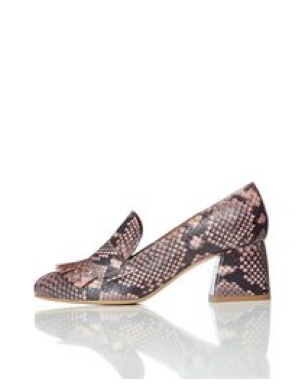

In [3]:
# 1. Check structure
print(df_img.shape)
print(df_img.columns)
print(df_img.dtypes)

# 2. Check missing values
print(df_img.notnull().sum())

# 3. Sample record
df_img.sample(5)

# 4. (If possible) display an image
from PIL import Image
import matplotlib.pyplot as plt

img_loc = str(df_img.loc[df_img['path']== '8c/8ccb5859.jpg']['path']).split()[1]
img_path = '/kaggle/input/amazon-berkeley-objects/images/small/' + img_loc  # based on image_id field
img = Image.open(img_path)
plt.imshow(img)
plt.axis('off')
plt.show()

In [4]:
# Load ABO metadata dataset

import os, glob
full_metadata = pd.DataFrame()
for json_file in glob.glob("/kaggle/input/listing/listings/metadata/*.json"):
    print('Loading file: ' + json_file + '\n')
    df_metadata = pd.read_json(json_file, lines = True)
    full_metadata = pd.concat([full_metadata, df_metadata])

Loading file: /kaggle/input/listing/listings/metadata/listings_3.json

Loading file: /kaggle/input/listing/listings/metadata/listings_d.json

Loading file: /kaggle/input/listing/listings/metadata/listings_b.json

Loading file: /kaggle/input/listing/listings/metadata/listings_a.json

Loading file: /kaggle/input/listing/listings/metadata/listings_4.json

Loading file: /kaggle/input/listing/listings/metadata/listings_8.json

Loading file: /kaggle/input/listing/listings/metadata/listings_9.json

Loading file: /kaggle/input/listing/listings/metadata/listings_f.json

Loading file: /kaggle/input/listing/listings/metadata/listings_0.json

Loading file: /kaggle/input/listing/listings/metadata/listings_6.json

Loading file: /kaggle/input/listing/listings/metadata/listings_c.json

Loading file: /kaggle/input/listing/listings/metadata/listings_2.json

Loading file: /kaggle/input/listing/listings/metadata/listings_5.json

Loading file: /kaggle/input/listing/listings/metadata/listings_1.json

Loadin

In [9]:
# 1. Check structure
print(full_metadata.shape)
print(full_metadata.columns)
print(full_metadata.dtypes)

(147702, 28)
Index(['brand', 'bullet_point', 'color', 'item_id', 'item_name', 'item_weight',
       'material', 'model_name', 'model_number', 'product_type',
       'main_image_id', 'other_image_id', 'item_keywords', 'country',
       'marketplace', 'domain_name', 'node', 'style', 'item_dimensions',
       'model_year', 'color_code', 'spin_id', '3dmodel_id', 'fabric_type',
       'item_shape', 'pattern', 'product_description', 'finish_type'],
      dtype='object')
brand                  object
bullet_point           object
color                  object
item_id                object
item_name              object
item_weight            object
material               object
model_name             object
model_number           object
product_type           object
main_image_id          object
other_image_id         object
item_keywords          object
country                object
marketplace            object
domain_name            object
node                   object
style                

In [21]:
# 2. Check missing values
full_metadata.isna().sum().sort_values(ascending=False)

finish_type            146166
product_description    143462
pattern                143112
item_shape             142636
model_year             139937
3dmodel_id             139742
fabric_type            139509
spin_id                139480
color_code             129459
style                  104514
item_dimensions        104364
material                94117
material_flat           94117
model_name              66123
model_name_flat         66123
item_weight_flat        41508
item_weight             41508
color                   31522
color_flat              31522
model_number            23611
model_number_flat       23611
item_keywords_flat      20926
item_keywords           20926
bullet_point_flat       16132
bullet_point            16132
other_image_id           9726
node_flat                6953
node                     6953
main_image_id             575
brand                      59
brand_flat                 59
item_id                     0
item_name                   0
country   

From above, "finish_type" column has the lowest number of values present i.e. 1536 (147702 - 146166)  out of 147702 product entries.

In [22]:
#Find duplicate item_id rows

duplicate_counts = full_metadata['item_id'].value_counts()
duplicate_counts = duplicate_counts[duplicate_counts > 1]
print(duplicate_counts)

item_id
B01BC2TBZ4    5
B00MEAYVH2    5
B00Q4TK5KG    5
B00Q6EY5UU    5
B07F87HC4V    4
             ..
B07R8FR8S4    2
B07Z58WTMK    2
B082MV768H    2
B06X9GMSD5    2
B07RPND47Z    2
Name: count, Length: 1932, dtype: int64


There are duplicates but analyising one of the item_id below.

In [23]:
full_metadata.loc[full_metadata['item_id'] == 'B01BC2TBZ4']

,brand,bullet_point,color,item_id,item_name,item_weight,material,model_name,model_number,product_type,main_image_id,other_image_id,item_keywords,country,marketplace,domain_name,node,style,item_dimensions,model_year,color_code,spin_id,3dmodel_id,fabric_type,item_shape,pattern,product_description,finish_type,brand_flat,bullet_point_flat,color_flat,item_name_flat,item_weight_flat,material_flat,model_name_flat,model_number_flat,product_type_flat,item_keywords_flat,node_flat
3100,"[{'language_tag': 'es_ES', 'value': 'AmazonBasics'}, {'language_tag': 'pt_PT', 'value': 'AmazonBasics'}]","[{'language_tag': 'es_ES', 'value': 'Juego de X o X fundas para proteger tu almohada.'}, {'language_tag': 'es_ES', 'value': 'Fabricadas de algodón 100% (85 g/m²) para una capa de confort extra.'}, {'language_tag': 'es_ES', 'value': 'Cremallera oculta para mantener la almohada en su sitio durante toda la noche.'}, {'language_tag': 'es_ES', 'value': 'Lavable en lavadora con colores similares (hasta 40 °C).'}, {'language_tag': 'es_ES', 'value': 'Cada una mide X x X cm.'}, {'language_tag': 'pt_PT', 'value': 'X ou X capas para proteger o seu travesseiro.'}, {'language_tag': 'pt_PT', 'value': 'Feito de algodão 100% (85g/m²) para uma camada extra de conforto.'}, {'language_tag': 'pt_PT', 'value': 'Zíper oculto para manter a almofada no lugar toda a noite.'}, {'language_tag': 'pt_PT', 'value': 'Lavável na máquina com cores semelhantes (até 40 °C).'}, {'language_tag': 'pt_PT', 'value': 'Cada uma mede x x x cm.'}]",NaN,B01BC2TBZ4,"[{'language_tag': 'es_ES', 'value': 'AmazonBasics 100% Cotton Soft Pillow Case with Zip'}, {'language_tag': 'pt_PT', 'value': 'AmazonBasics 100% Cotton Soft Pillow Case with Zip'}]",NaN,NaN,NaN,NaN,[{'value': 'HOME_BED_AND_BATH'}],71hiSKP7S6L,[71vbYUabUlL],"[{'language_tag': 'es_ES', 'value': 'EFN_UKES_mllutter'}, {'language_tag': 'pt_PT', 'value': 'EFN_UKES_mllutter'}]",ES,Amazon,amazon.es,"[{'node_id': 3250027031, 'node_name': '/Categorías/Textiles del hogar/Ropa de cama y almohadas/Sábanas y fundas de almohada/Fundas para almohada'}]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"AmazonBasics, AmazonBasics","Juego de X o X fundas para proteger tu almohada., Fabricadas de algodón 100% (85 g/m²) para una capa de confort extra., Cremallera oculta para mantener la almohada en su sitio durante toda la noche., Lavable en lavadora con colores similares (hasta 40 °C)., Cada una mide X x X cm., X ou X capas para proteger o seu travesseiro., Feito de algodão 100% (85g/m²) para uma camada extra de conforto., Zíper oculto para manter a almofada no lugar toda a noite., Lavável na máquina com cores semelhantes (até 40 °C)., Cada uma mede x x x cm.",None,"AmazonBasics 100% Cotton Soft Pillow Case with Zip, AmazonBasics 100% Cotton Soft Pillow Case with Zip",None,None,None,None,HOME_BED_AND_BATH,"EFN_UKES_mllutter, EFN_UKES_mllutter",/Categorías/Textiles del hogar/Ropa de cama y almohadas/Sábanas y fundas de almohada/Fundas para almohada
5348,"[{'language_tag': 'it_IT', 'value': 'AmazonBasics'}]","[{'language_tag': 'it_IT', 'value': 'Set di X o X federe copricuscino.'}, {'language_tag': 'it_IT', 'value': 'Realizzate in 100% cotone (85 g/mq) per aggiungere uno strato extra di morbido comfort.'}, {'language_tag': 'it_IT', 'value': 'Cerniera nascosta per tenere il cuscino in posizione durante la notte.'}, {'language_tag': 'it_IT', 'value': 'Lavabili in lavatrice con colori simili (fino a 40°C).'}, {'language_tag': 'it_IT', 'value': 'Dimensioni: X x X cm ciascuna.'}]",NaN,B01BC2TBZ4,"[{'language_tag': 'it_IT', 'value': 'AmazonBasics 100% Cotton Soft Pillow Case with Zip'}]",NaN,NaN,NaN,NaN,[{'value': 'HOME_BED_AND_BATH'}],413jqtAkNSL,"[61zQgNq1DtL, 616p93l+d5L, 61ZKCJ0ilkL, 61i6maIErCL, 71vbYUabUlL, 71wsn+knMWL]","[{'language_tag': 'it_IT', 'value': 'efn_ukit_mllutter'}]",IT,Amazon,amazon.it,"[{'node_id': 731786031, 'node_name': '/Categorie/Tessili per la casa/Biancheria da letto/Lenzuola e federe/Federe'}]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

There are duplicate item_ids, because of multiple language support. We will remove duplicates after creating 
a scoped dataframe for supported language.

In [24]:
# 3. Sample record
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
#full_metadata.sample(5)

From above, it is clear that:
1. Only **item_name** column is present for all products.
2. We will use **item_name** to filter for in scope language - English.

In [25]:
# 4. Display an image using image id from the metadata

from PIL import Image
import matplotlib.pyplot as plt
print(full_metadata.loc[full_metadata['main_image_id'] == '413jqtAkNSL'])

                                                     brand  \
5348  [{'language_tag': 'it_IT', 'value': 'AmazonBasics'}]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    bullet_point  \
5348  [{'language_tag': 'it_IT', 'value': 'Set di X o X federe copricuscino.'}, {'language_tag': 'it_IT', 'value': 'Realizzate in 100% cotone (85 g/mq) per aggiungere uno strato extra di morbido comfort.'}, {'language_tag': 'it_IT', 'value': 'Cerniera nascosta per tenere il cuscino in posizione durante la notte.'}, {'language_tag': 'it_IT', 'value': 'Lavabili in lavatrice con colori simil

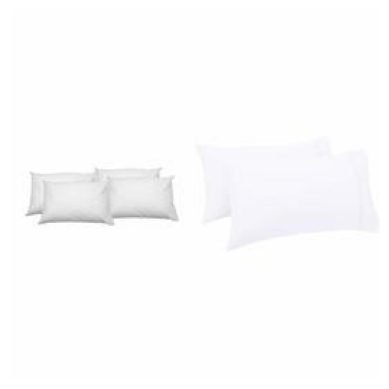

In [26]:
img_row = full_metadata.loc[full_metadata['main_image_id'] == '413jqtAkNSL']
img_id = img_row.iloc[0]['main_image_id']
img_location = str(df_img.loc[df_img['image_id'] == img_id]['path'])
img = Image.open('/kaggle/input/amazon-berkeley-objects/images/small/' + img_location.split()[1])
plt.imshow(img)
plt.axis('off')
plt.show()

In [27]:
# Analyse the number of languages supported. US-English in scope only.
count_US_lang_key = 0
count_prodDesc = 0
count_total=0
lang_set = set()
for val in full_metadata['item_name']:
    count_total += 1
    for key, value in val[0].items():
        if(key == 'language_tag'):
            lang_set.add(value)
print(lang_set)

{'fr_CA', 'ml_IN', 'en_SG', 'en_AU', 'sv_SE', 'en_GB', 'zh_CN', 'pt_BR', 'ar_AE', 'ko_KR', 'it_IT', 'zh_TW', 'te_IN', 'hi_IN', 'fr_FR', 'de_DE', 'es_US', 'he_IL', 'nl_NL', 'en_IN', 'kn_IN', 'cs_CZ', 'en_AE', 'pl_PL', 'ja_JP', 'es_ES', 'en_CA', 'tr_TR', 'es_MX', 'en_US'}


Amongst these, only English language will be used. i.e,
en_SG,
en_CA,
en_AU,
en_GB, 
en_AE, 
en_US,
en_IN

In [ ]:
valid_languages = {'en_SG', 'en_CA', 'en_AU', 'en_GB', 'en_AE', 'en_US', 'en_IN'}

countTotalProdDesc = 0
countTotalEngDesc = 0

for val in full_metadata['item_name']:
    if isinstance(val, list):
        for item in val:
            if isinstance(item, dict):
                countTotalProdDesc += 1
                if item.get('language_tag') in valid_languages:
                    countTotalEngDesc += 1

print('Total language-tagged entries (all languages):', countTotalProdDesc)
print('Total in-scope English entries:', countTotalEngDesc)
print('Percentage of data under scope:', round(countTotalEngDesc / countTotalProdDesc * 100, 2), '%')

In [33]:
# Reduce the metadata to in scope languages only
def has_valid_language(item_name):
    if isinstance(item_name, list):
        return any(
            isinstance(entry, dict) and entry.get('language_tag') in valid_languages
            for entry in item_name
        )
    return False

inScopeMetadata = full_metadata[full_metadata['item_name'].apply(has_valid_language)].reset_index(drop=True)

In [34]:
print(inScopeMetadata.shape)

(122734, 39)


In [36]:
def get_first_valid_lang(item_name):
    if isinstance(item_name, list):
        for entry in item_name:
            if isinstance(entry, dict) and entry.get('language_tag') in valid_languages:
                return entry['language_tag']
    return None

full_metadata['language_matched'] = full_metadata['item_name'].apply(get_first_valid_lang)

In [37]:
print(f"Total rows with valid English variants: {len(inScopeMetadata)} / {len(full_metadata)}")

Total rows with valid English variants: 122734 / 147702


In [31]:
#Find duplicate item_id rows

duplicate_counts = inScopeMetadata['item_id'].value_counts()
duplicate_counts = duplicate_counts[duplicate_counts > 1]
print(duplicate_counts)

item_id
B07WC622LH    28
B0746MMVXW    28
B07797D9MW    27
B073S3R169    26
B01928HSB4    26
              ..
B07GN662BP     7
B07RRWD8QB     7
B07HFTZ8YW     7
B07RR3RFHT     7
B01719EX2S     7
Name: count, Length: 9225, dtype: int64


In [32]:
inScopeMetadata.loc[inScopeMetadata['item_id'] == 'B07WC622LH']

,brand,bullet_point,color,item_id,item_name,item_weight,material,model_name,model_number,product_type,main_image_id,other_image_id,item_keywords,country,marketplace,domain_name,node,style,item_dimensions,model_year,color_code,spin_id,3dmodel_id,fabric_type,item_shape,pattern,product_description,finish_type,brand_flat,bullet_point_flat,color_flat,item_name_flat,item_weight_flat,material_flat,model_name_flat,model_number_flat,product_type_flat,item_keywords_flat,node_flat
5668,"[{'language_tag': 'en_CA', 'value': 'find.'}]",NaN,"[{'language_tag': 'en_CA', 'standardized_values': ['Blue'], 'value': 'Blue Navy'}]",B07WC622LH,"[{'language_tag': 'en_CA', 'value': 'find. Women's Flat Crossover Leather, Blue (Navy), 39 EU'}]",NaN,NaN,"[{'language_tag': 'en_CA', 'value': 'SANA-1W3-039'}]",[{'value': 'SANA-1W3-039'}],[{'value': 'SHOES'}],51U-SwG84eL,"[81myHmi4lJL, 912sGbwqDQL, 714HaF786LL, 71eoKhQ2moL]","[{'language_tag': 'en_CA', 'value': 'UK'}]",CA,Amazon,amazon.ca,"[{'node_id': 10287465011, 'node_name': '/Categories/Women/Clothing'}, {'node_id': 10293415011, 'node_name': '/Categories/Women/Shoes'}]","[{'language_tag': 'en_CA', 'value': 'Open Toe Sandals'}]",NaN,[{'value': 2019}],[#5D555B],NaN,NaN,NaN,NaN,NaN,NaN,NaN,find.,None,Blue Navy,"find. Women's Flat Crossover Leather, Blue (Navy), 39 EU",None,None,SANA-1W3-039,SANA-1W3-039,SHOES,UK,"/Categories/Women/Clothing, /Categories/Women/Shoes"
6219,"[{'language_tag': 'de_DE', 'value': 'find.'}]",NaN,"[{'language_tag': 'de_DE', 'standardized_values': ['Blau'], 'value': 'Blau Navy'}]",B07WC622LH,"[{'language_tag': 'en_GB', 'value': 'Amazon Brand: Find Sana-1w3-039 Women's Open Sandals, 39 eu'}, {'language_tag': 'de_DE', 'value': 'Amazon-Marke: FIND Flat Crossover Leather Offene Sandalen, Blau (Navy), 39 EU'}]",NaN,NaN,"[{'language_tag': 'en_GB', 'value': 'Sana-1w3-039'}, {'language_tag': 'de_DE', 'value': 'Sana-1w3-039'}]",[{'value': 'SANA-1W3-039'}],[{'value': 'SHOES'}],51U-SwG84eL,"[81myHmi4lJL, 912sGbwqDQL, 714HaF786LL, 71eoKhQ2moL]","[{'language_tag': 'de_DE', 'value': 'DE;'}]",DE,Amazon,amazon.de,"[{'node_id': 1760312031, 'node_name': '/Kategorien/Schuhe/Damen/Sandalen & Slides/Sandalen'}]","[{'language_tag': 'en_GB', 'value': 'Open Sandals with Wedge Heel'}, {'language_tag': 'de_DE', 'value': 'Offene Sandalen mit Keilabsatz'}]",NaN,[{'value': 2019}],[#5D555B],NaN,NaN,NaN,NaN,NaN,NaN,NaN,find.,None,Blau Navy,"Amazon Brand: Find Sana-1w3-039 Women's Open Sandals, 39 eu, Amazon-Marke: FIND Flat Crossover Leather Offene Sandalen, Blau (Navy), 39 EU",None,None,"Sana-1w3-039, Sana-1w3-039",SANA-1W3-039,SHOES,DE;,/Kategorien/Schuhe/Damen/Sandalen & Slides/Sandalen
13337,"[{'language_tag': 'en_CA', 'value': 'find.'}]",NaN,"[{'language_tag': 'en_CA', 'standardized_values': ['Blue'], 'value': 'Blue Navy'}]",B07WC622LH,"[{'language_tag': 'en_CA', 'value': 'find. Women's Flat Crossover Leather, Blue (Navy), 39 EU'}]",NaN,NaN,"[{'language_tag': 'en_CA', 'value': 'SANA-1W3-039'}]",[{'value': 'SANA-1W3-039'}],[{'value': 'SHOES'}],51U-SwG84eL,"[81myHmi4lJL, 912sGbwqDQL, 714HaF786LL, 71eoKhQ2moL]","[{'language_tag': 'en_CA', 'value': 'UK'}]",CA,Amazon,amazon.ca,"[{'node_id': 10287465011, 'node_name': '/Categories/Women/Clothing'}, {'node_id': 10293415011, 'node_name': '/Categories/Women/Shoes'}]","[{'language_tag': 'en_CA', 'value': 'Open Toe Sandals'}]",NaN,[{'value': 2019}],[#5D555B],NaN,NaN,NaN,NaN,NaN,NaN,NaN,find.,None,Blue Navy,"find. Women's Flat Crossover Leather, Blue (Navy), 39 EU",None,None,SANA-1W3-039,SANA-1W3-039,SHOES,UK,"/Categories/Women/Clothing, /Categories/Women/Shoes"
13891,"[{'language_tag': 'de_DE', 'value': 'find.'}]",NaN,"[{'language_tag': 'de_DE', 'standardized_values': ['Blau'], 'value': 'Blau Navy'}]",B07WC622LH,"[{'language_tag': 'en_GB', 'value': 'Amazon Brand: Find Sana-1w3-039 Women's Open Sandals, 39 eu'}, {'language_tag': 'de_DE', 'value': 'Amazon-Marke: FIND Flat Crossover Leather Offene Sandalen, Blau (Navy), 39 EU'}]",NaN,NaN,"[{'language_tag': 'en_GB', 'value': 

In [12]:
def auto_flatten_json_columns(df, keys_to_try=['value', 'name', 'node_name']):
    """
    Detects and flattens columns containing lists of JSON objects,
    extracting specified keys.
    Adds new columns with a `_flat` suffix.
    """
    def extract_from_list(ld, keys):
        if isinstance(ld, list):
            for key in keys:
                values = [str(d.get(key)) for d in ld if isinstance(d, dict) and key in d]
                if values:  # found at least one valid value
                    return ", ".join(values)
        return None

    # Track flattened columns
    flattened = []

    for col in df.columns:
        sample = df[col].iloc[0]
        if isinstance(sample, list) and all(isinstance(i, dict) for i in sample):
            flat_col = f"{col}_flat"
            df[flat_col] = df[col].apply(lambda x: extract_from_list(x, keys_to_try))
            flattened.append(flat_col)

    return df, flattened

In [ ]:
print(inScopeMetadata.shape)

In [ ]:
inScopeMetadata, flattened_cols = auto_flatten_json_columns(inScopeMetadata)
print("Flattened columns:", flattened_cols)


In [ ]:
print(inScopeMetadata.columns)

In [13]:
print(full_metadata.shape)

(147702, 28)


In [14]:
full_metadata, flattened_cols = auto_flatten_json_columns(full_metadata)
print("Flattened columns:", flattened_cols)

Flattened columns: ['brand_flat', 'bullet_point_flat', 'color_flat', 'item_name_flat', 'item_weight_flat', 'material_flat', 'model_name_flat', 'model_number_flat', 'product_type_flat', 'item_keywords_flat', 'node_flat']


In [15]:
print(full_metadata.shape)

(147702, 39)


In [ ]:
print(full_metadata.dtypes)

In [ ]:
# 2. Check missing values
print(full_metadata.notnull().sum())

In [ ]:
print(full_metadata.index[:10])

In [ ]:
full_metadata = full_metadata.reset_index(drop=True)

In [ ]:
print(full_metadata.loc[1])  # Row with index label 1

In [ ]:
print(full_metadata.columns)

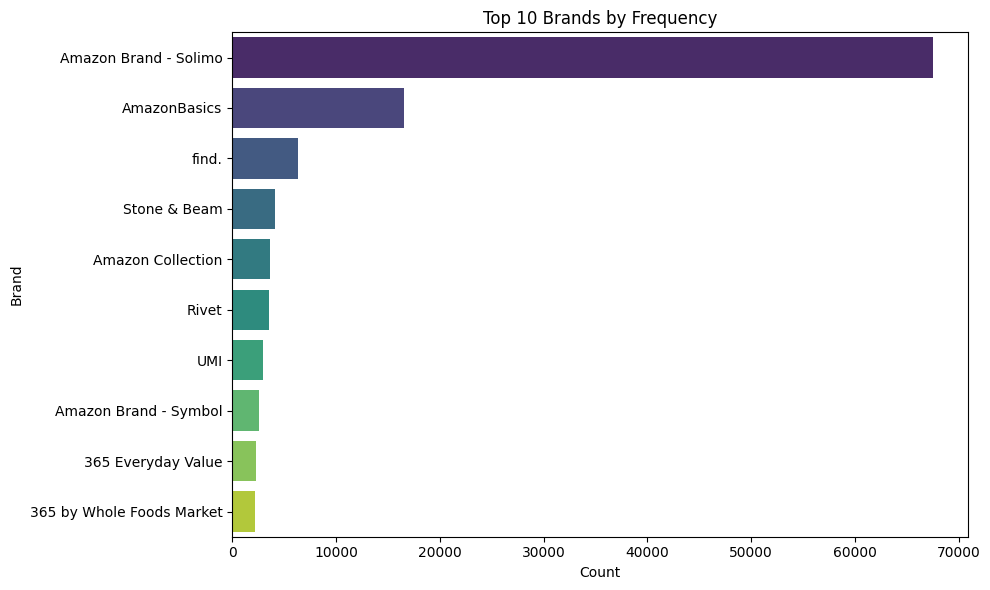

In [16]:
#1. Top 10 Brands

import matplotlib.pyplot as plt
import seaborn as sns

top_brands = full_metadata['brand_flat'].value_counts().head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_brands.values, y=top_brands.index, palette='viridis')
plt.title("Top 10 Brands by Frequency")
plt.xlabel("Count")
plt.ylabel("Brand")
plt.tight_layout()
plt.show()

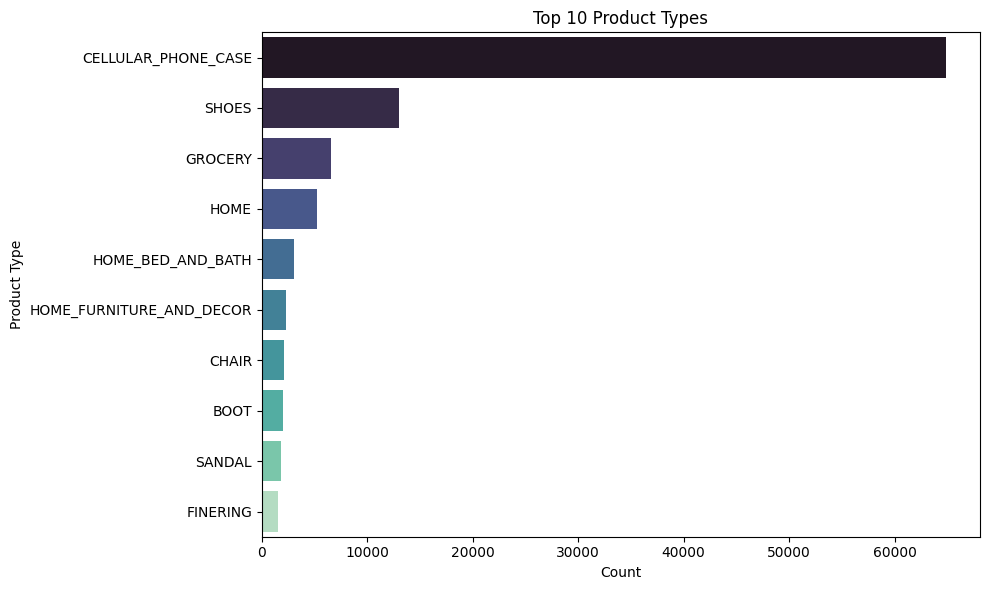

In [17]:
# Top 10 product types

top_types = full_metadata['product_type_flat'].value_counts().head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_types.values, y=top_types.index, palette='mako')
plt.title("Top 10 Product Types")
plt.xlabel("Count")
plt.ylabel("Product Type")
plt.tight_layout()
plt.show()

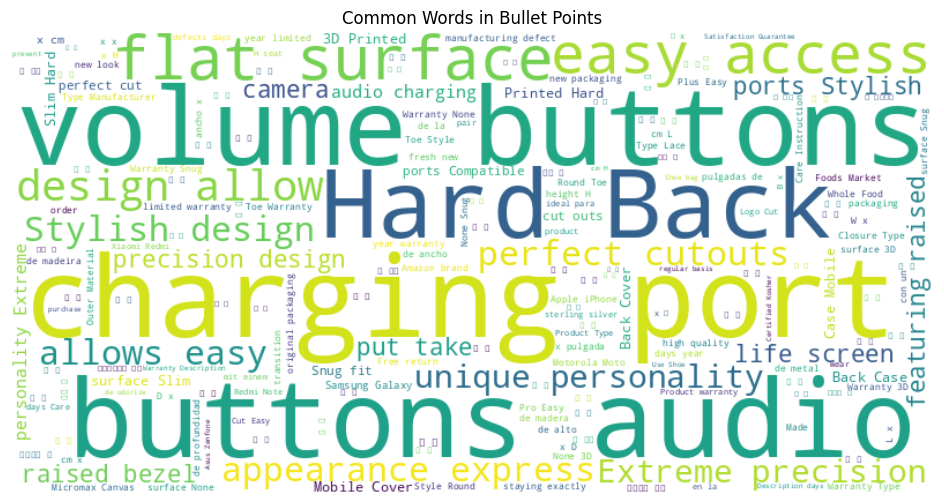

In [18]:
#Word cloud from bullet_point information

from wordcloud import WordCloud

text = " ".join(full_metadata['bullet_point_flat'].dropna().astype(str).values)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Common Words in Bullet Points")
plt.show()

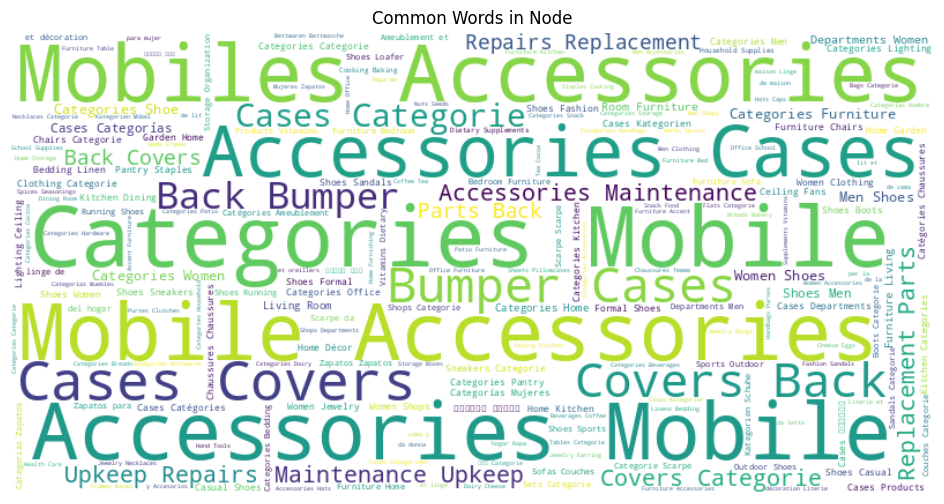

In [19]:
#Word cloud from node information

from wordcloud import WordCloud

text = " ".join(full_metadata['node_flat'].dropna().astype(str).values)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Common Words in Node")
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=full_metadata, x='domain_name', order=full_metadata['domain_name'].value_counts().index)
plt.title("Items per Domain")
plt.xlabel("Domain")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Above plots show:
1. More than half of the items are on "Amazon" marketplace.
2. Cellular phone Case, Shoes, Grocery are top 3 product types.
3. Amazon.in accounts for more than half of listings.
4. Words around mobile accessories dominate the product's catefories description column (node).
5. Multiple languages are supported per product. Languages list:
{'ko_KR', 'es_MX', 'zh_TW', 'sv_SE', 'en_AU', 'fr_CA', 'en_CA', 'he_IL', 'es_US', 'kn_IN', 'tr_TR', 'hi_IN', 'zh_CN', 'en_GB', 'nl_NL', 'pt_BR', 'fr_FR', 'te_IN', 'ja_JP', 'en_IN', 'es_ES', 'en_US', 'ar_AE', 'en_SG', 'ml_IN', 'en_AE', 'cs_CZ', 'it_IT', 'pl_PL', 'de_DE'}

The full_metadata will be used

In [ ]:
#Serialize to parquet/persistent storage

inScopeMetadata.to_parquet("inScopeMetadata_with_embeddings.parquet", index=False)


With above copy, we have:

inScopeMetadata_with_embeddings.parquet → all metadata + embedding inputs